In [1]:
import pandas as pd
import os

In [ ]:
# get all txt files in folder
DFS : dict(pd.DataFrame) = {}

for dirpath, dirnames, filenames in os.walk('data/20220715_191941/3/google_transit'):
    for filename in filenames:
        if filename.rstrip('.txt') not in DFS.keys():
            DFS[filename.rstrip('.txt')] = os.path.join(dirpath, filename)

for key in DFS:
    DFS[key] = pd.read_csv(DFS[key])

# create a dictionary that list all dates that a service operates on

df_calendar: pd.DataFrame = DFS['calendar']
df_calendar['start_date'] = df_calendar['start_date'].transform(
    lambda x: pd.to_datetime(format="%Y%m%d", arg=x))
df_calendar['end_date'] = df_calendar['end_date'].transform(
    lambda x: pd.to_datetime(format="%Y%m%d", arg=x))
df_calendar = df_calendar.rename(
    columns={
        'monday': 0,
        'tuesday': 1,
        'wednesday': 2,
        'thursday': 3,
        'friday': 4,
        'saturday': 5,
        'sunday': 6
    })

sf_calendar = df_calendar.set_index('service_id').to_dict(orient='index').items()

sf_calendar_dates: pd.DataFrame = DFS['calendar_dates']
sf_calendar_dates['date'] = sf_calendar_dates['date'].transform(
    lambda x: pd.to_datetime(format="%Y%m%d", arg=x))
sf_calendar_dates = sf_calendar_dates.groupby(
    ['service_id', 'exception_type']).apply(lambda gdf: gdf['date'].tolist())

service_dates = {}

for service_id, service_values in sf_calendar:

    service_dates[service_id] = [t for t in pd.date_range(
        service_values['start_date'], service_values['end_date']) if service_values[t.day_of_week] == 1]

    if(service_id in sf_calendar_dates.index.levels[0] and 2 in sf_calendar_dates.index.levels[1]):
        service_dates[service_id] = [
            t for t in service_dates[service_id] if t not in sf_calendar_dates[service_id][2]]

service_dates


In [72]:
df_trips : pd.DataFrame = DFS['trips']
TRIPS = pd.Series(df_trips.set_index('trip_id', drop=False).to_dict('index'))

trips_stop_times = DFS['stop_times'].groupby('trip_id').apply(lambda x: x.to_dict('records'))

def add_more_properties_to_trips(x : dict):
    x['dates'] = service_dates[x['service_id']]
    x['stop_times'] = trips_stop_times[x['trip_id']]
    return x

TRIPS = TRIPS.apply(add_more_properties_to_trips)


1561.UJ.3-109-A-mjp-1.2.H    {'route_id': '3-109-A-mjp-1', 'service_id': 'U...
1562.UJ.3-109-A-mjp-1.2.H    {'route_id': '3-109-A-mjp-1', 'service_id': 'U...
1563.UJ.3-109-A-mjp-1.2.H    {'route_id': '3-109-A-mjp-1', 'service_id': 'U...
1564.UJ.3-109-A-mjp-1.2.H    {'route_id': '3-109-A-mjp-1', 'service_id': 'U...
1565.UJ.3-109-A-mjp-1.2.H    {'route_id': '3-109-A-mjp-1', 'service_id': 'U...
                                                   ...                        
7594.T0.3-96-A-mjp-1.2.H     {'route_id': '3-96-A-mjp-1', 'service_id': 'T0...
7595.T0.3-96-A-mjp-1.2.H     {'route_id': '3-96-A-mjp-1', 'service_id': 'T0...
7596.T0.3-96-A-mjp-1.2.H     {'route_id': '3-96-A-mjp-1', 'service_id': 'T0...
7597.T0.3-96-A-mjp-1.2.H     {'route_id': '3-96-A-mjp-1', 'service_id': 'T0...
7598.T0.3-96-A-mjp-1.2.H     {'route_id': '3-96-A-mjp-1', 'service_id': 'T0...
Length: 17971, dtype: object

In [80]:
# filter data
# get needed trips
routes_needed = DFS['routes'].groupby('route_short_name').get_group('59')['route_id'].tolist()

df_trips_needed = DFS['trips'][DFS['trips']['route_id'].isin(routes_needed)]
trips_needed = df_trips_needed['trip_id'].tolist()

In [83]:
TRIPS[TRIPS.index.isin(trips_needed)]

1000.UJ.3-59-A-mjp-1.2.H    {'route_id': '3-59-A-mjp-1', 'service_id': 'UJ...
1001.UJ.3-59-A-mjp-1.2.H    {'route_id': '3-59-A-mjp-1', 'service_id': 'UJ...
1016.UJ.3-59-A-mjp-1.2.H    {'route_id': '3-59-A-mjp-1', 'service_id': 'UJ...
1017.UJ.3-59-A-mjp-1.5.R    {'route_id': '3-59-A-mjp-1', 'service_id': 'UJ...
1018.UJ.3-59-A-mjp-1.5.R    {'route_id': '3-59-A-mjp-1', 'service_id': 'UJ...
                                                  ...                        
986.UJ.3-59-A-mjp-1.4.R     {'route_id': '3-59-A-mjp-1', 'service_id': 'UJ...
987.UJ.3-59-A-mjp-1.2.H     {'route_id': '3-59-A-mjp-1', 'service_id': 'UJ...
997.UJ.3-59-A-mjp-1.4.R     {'route_id': '3-59-A-mjp-1', 'service_id': 'UJ...
998.UJ.3-59-A-mjp-1.2.H     {'route_id': '3-59-A-mjp-1', 'service_id': 'UJ...
999.UJ.3-59-A-mjp-1.4.R     {'route_id': '3-59-A-mjp-1', 'service_id': 'UJ...
Length: 917, dtype: object

In [93]:
DFS['stops'][DFS['stops']['stop_name'].isin(['28-Middle St/Mt Alexander Rd (Ascot Vale)'])]['stop_id'].tolist()

,stop_id,stop_name,stop_lat,stop_lon
817,19265,28-Middle St/Mt Alexander Rd (Ascot Vale),-37.777457,144.929833
1036,19603,28-Middle St/Mt Alexander Rd (Ascot Vale),-37.777699,144.929770


In [145]:


def transform_gtfs_time(time : str):
    splitted = time.split(':')
    return pd.Timedelta(hours=int(splitted[0]), minutes=int(splitted[1]), seconds=int(splitted[2]))

def get_arrivals_and_departures_timestamps(x : pd.Series):
    x['arrivals'] = list(map(lambda d: (d + transform_gtfs_time(x['arrival_time'])).timestamp(), TRIPS[x['trip_id']]['dates']))
    x['departures'] = list(map(lambda d: (d + transform_gtfs_time(x['departure_time'])).timestamp(), TRIPS[x['trip_id']]['dates']))
    return x

def get_all_timestamps_for_stop_id(df: pd.DataFrame):
    return {
        'arrivals': df['arrivals'].sum(),
        'departures': df['departures'].sum()
    }

stops_timestamps : pd.DataFrame = DFS['stop_times'][DFS['stop_times']['stop_id'].isin(DFS['stops'][DFS['stops']['stop_name'].isin(['28-Middle St/Mt Alexander Rd (Ascot Vale)'])]['stop_id'].tolist())].apply(axis=1, func=get_arrivals_and_departures_timestamps).groupby('stop_id').apply(get_all_timestamps_for_stop_id)

stop_id
19265    {'arrivals': [1658050920.0, 1658655720.0, 1659...
19603    {'arrivals': [1658048160.0, 1658652960.0, 1659...
dtype: object

In [217]:
# k = [(pd.to_datetime(x, unit='s').second, pd.to_datetime(x, unit='s').day_of_week) for x in stops_timestamps[19265]['arrivals']]
def temp(x):
    time = pd.to_datetime(x, unit='s')
    return (time.second * 60 + time.minute) * 60 + time.hour
stops_timestamps[19265]['arrivals'].sort()
arr = stops_timestamps[19265]['arrivals']
arr

[1657777140.0,
 1657777860.0,
 1657778580.0,
 1657779300.0,
 1657779960.0,
 1657780440.0,
 1657780920.0,
 1657781400.0,
 1657781820.0,
 1657782300.0,
 1657782780.0,
 1657783200.0,
 1657783620.0,
 1657783980.0,
 1657784400.0,
 1657784700.0,
 1657785060.0,
 1657785360.0,
 1657785780.0,
 1657786140.0,
 1657786500.0,
 1657786860.0,
 1657787220.0,
 1657787580.0,
 1657787940.0,
 1657788360.0,
 1657788780.0,
 1657789200.0,
 1657789500.0,
 1657789860.0,
 1657790340.0,
 1657790760.0,
 1657791060.0,
 1657791360.0,
 1657791720.0,
 1657792200.0,
 1657792680.0,
 1657793160.0,
 1657793640.0,
 1657794120.0,
 1657794600.0,
 1657795080.0,
 1657795560.0,
 1657796040.0,
 1657796520.0,
 1657797000.0,
 1657797480.0,
 1657797960.0,
 1657798440.0,
 1657798920.0,
 1657799400.0,
 1657799880.0,
 1657800360.0,
 1657800840.0,
 1657801320.0,
 1657801800.0,
 1657802280.0,
 1657802760.0,
 1657803240.0,
 1657803720.0,
 1657804200.0,
 1657804680.0,
 1657805160.0,
 1657805640.0,
 1657806120.0,
 1657806600.0,
 165780708

In [218]:
y = []
x = []
for i in range(1, len(arr)):
    y.append(arr[i] - arr[i-1])
    timex = pd.to_datetime(arr[i], unit='s')
    x.append((timex.second * 60 + timex.minute) * 60 + timex.hour)


In [182]:
import matplotlib.pyplot as plt
import numpy as np

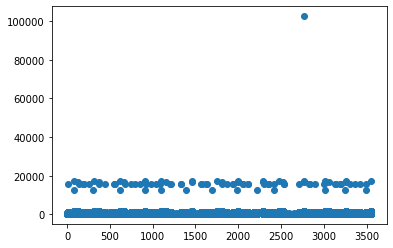

In [220]:
plt.scatter(y, x)

In [155]:
DFS['stops'][DFS['stops']['stop_name'].isin(['1-Flinders Street Railway Station/Elizabeth St (Melbourne City)'])], DFS['stops'][DFS['stops']['stop_name'].isin(['28-Middle St/Mt Alexander Rd (Ascot Vale)'])]

(     stop_id                                          stop_name   stop_lat  \
 121    17850  1-Flinders Street Railway Station/Elizabeth St... -37.817717   
 142    17877  1-Flinders Street Railway Station/Elizabeth St... -37.817899   
 
        stop_lon  
 121  144.964765  
 142  144.964840  ,
       stop_id                                  stop_name   stop_lat  \
 817     19265  28-Middle St/Mt Alexander Rd (Ascot Vale) -37.777457   
 1036    19603  28-Middle St/Mt Alexander Rd (Ascot Vale) -37.777699   
 
         stop_lon  
 817   144.929833  
 1036  144.929770  )

In [169]:
DFS['stop_times'][DFS['stop_times']['trip_id'] == '1000.UJ.3-59-A-mjp-1.2.H'].merge(DFS['stops'][['stop_id', 'stop_name']], on='stop_id')

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,stop_name
0,1000.UJ.3-59-A-mjp-1.2.H,09:19:00,09:19:00,19482,1,NaN,0,0,0.00,59-Airport West/Matthews Ave (Airport West)
1,1000.UJ.3-59-A-mjp-1.2.H,09:20:00,09:20:00,19481,2,NaN,0,0,536.41,58-Marshall Rd/Matthews Ave (Airport West)
2,1000.UJ.3-59-A-mjp-1.2.H,09:21:00,09:21:00,19480,3,NaN,0,0,1060.87,57-Hawker St/Matthews Ave (Airport West)
3,1000.UJ.3-59-A-mjp-1.2.H,09:22:00,09:22:00,19479,4,NaN,0,0,1538.44,56-Earl St/Matthews Ave (Airport West)
4,1000.UJ.3-59-A-mjp-1.2.H,09:23:00,09:23:00,19478,5,NaN,0,0,1828.71,55-Cameron St/Matthews Ave (Airport West)
5,1000.UJ.3-59-A-mjp-1.2.H,09:23:00,09:23:00,19477,6,NaN,0,0,2102.83,54-Fullarton Rd/Matthews Ave (Niddrie)
6,1000.UJ.3-59-A-mjp-1.2.H,09:24:00,09:24:00,19475,7,NaN,0,0,2428.30,53-Keilor Rd/Matthews Ave (Niddrie)
7,1000.UJ.3-59-A-mjp-1.2.H,09:25:00,09:25:00,22305,8,NaN,0,0,2821.12,52-Treadwell Rd/Keilor Rd (Niddrie)
8,1000.UJ.3-59-A-mjp-1.2.H,09:26:00,09:26:00,21196,9,NaN,0,0,3161.19,51-Bradshaw St/Keilor Rd (Essendon)
9,1000.UJ.3-59-A-mjp-1.2.H,09:27:00,09:27:00,19473,10,NaN,0,0,3511.30,50-Cooper St/Keilor Rd (Essendon North)


In [164]:
DFS['trips'][DFS['trips']['trip_headsign'].isin(['Airport West to Flinders Street Station (City)', 'Flinders Street Station, City to Airport West'])]

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
9158,3-59-A-mjp-1,UJ,1000.UJ.3-59-A-mjp-1.2.H,3-59-A-mjp-1.2.H,Airport West to Flinders Street Station (City),0
9159,3-59-A-mjp-1,UJ,1001.UJ.3-59-A-mjp-1.2.H,3-59-A-mjp-1.2.H,Airport West to Flinders Street Station (City),0
9160,3-59-A-mjp-1,UJ,1016.UJ.3-59-A-mjp-1.2.H,3-59-A-mjp-1.2.H,Airport West to Flinders Street Station (City),0
9161,3-59-A-mjp-1,UJ,1017.UJ.3-59-A-mjp-1.5.R,3-59-A-mjp-1.5.R,"Flinders Street Station, City to Airport West",1
9162,3-59-A-mjp-1,UJ,1018.UJ.3-59-A-mjp-1.5.R,3-59-A-mjp-1.5.R,"Flinders Street Station, City to Airport West",1
...,...,...,...,...,...,...
10070,3-59-A-mjp-1,UJ,986.UJ.3-59-A-mjp-1.4.R,3-59-A-mjp-1.4.R,"Flinders Street Station, City to Airport West",1
10071,3-59-A-mjp-1,UJ,987.UJ.3-59-A-mjp-1.2.H,3-59-A-mjp-1.2.H,Airport West to Flinders Street Station (City),0
10072,3-59-A-mjp-1,UJ,997.UJ.3-59-A-mjp-1.4.R,3-59-A-mjp-1.4.R,"Flinders Street Station, City to Airport West",1
10073,3-59-A-mjp-1,UJ,998.UJ.3-59-A-mjp-1.2.H,3-59-A-mjp-1.2.H,Airport West to Flinders Street Station (City),0
